CNN Architecture: The Convolutional Neural Network approach processes 30-second epochs of EEG data, specifically using the 'EEG C3-REF' channel as a primary input source. The architecture consists of a single 1D convolutional layer with 16 filters and a kernel size of 3, using ReLU activation. The convolutional features are then flattened and passed through a dense layer of 64 units with ReLU activation, before reaching the final softmax layer with 5 output neurons corresponding to the sleep stages (W, N1, N2, N3, R). The model was trained using the Adam optimizer with categorical cross-entropy loss for 10 epochs. This relatively simple architecture achieved a test accuracy of 42.1%, demonstrating basic capability in distinguishing between sleep stages while leaving room for potential improvements through architectural enhancements. 

Read the excel data for sleep stages and the corresponding EEG data. The data is in the form of a 2D array where each row corresponds to a 30 second epoch. The first column contains the sleep stage and the remaining columns contain the EEG data. The EEG data is sampled at 100 Hz. The sleep stages are encoded as follows:

Read the EEG file, splitting each 30 second

In [1]:
import mne
import os
import pandas as pd
import numpy as np

# Path to the directory containing the subdirectories
parent_dir = "data"
# Sampling frequency  
sampling_frequency = 500   

# Create a list to hold the processed data
processed_data = []

# Fallback channel to use if Fpz-Cz derivation is not possible
fallback_channel = "EEG C3-REF"

# Loop through each subdirectory (e.g., p8, p9, etc.)
for subdir in os.listdir(parent_dir):
    subdir_path = os.path.join(parent_dir, subdir)
    if os.path.isdir(subdir_path):  # Check if it's a directory
        # Match CSV and EDF files
        csv_file = None
        edf_file = None
        for file in os.listdir(subdir_path):
            if file.startswith("PSG_sleepstages_") and file.endswith(".csv"):
                csv_file = os.path.join(subdir_path, file)
            elif file.startswith("PSG_raw_WPS_") and file.endswith(".edf"):
                edf_file = os.path.join(subdir_path, file)

        if csv_file and edf_file:
            print(f"Processing EDF: {edf_file} with CSV: {csv_file}")
            
            # Read the labels from the CSV file
            labels_df = pd.read_csv(csv_file)

            # Normalize column names to handle spaces or inconsistencies
            labels_df.columns = labels_df.columns.str.strip()
            
            # Locate the 'Sleep Stage' column
            sleep_stage_column = [col for col in labels_df.columns if col.lower() == "sleep stage"]
            if sleep_stage_column:
                sleep_stage_column = sleep_stage_column[0]  # Get the exact column name
                print(f"Using column: {sleep_stage_column}")
            else:
                print(f"No 'Sleep Stage' column found in {csv_file}. Skipping.")
                continue

            # Try reading the EDF file using MNE
            try:
                raw = mne.io.read_raw_edf(edf_file, preload=False, verbose=False)
                print(raw.info)
                # print channel name
                print(raw.ch_names)
                # Use the fallback channel if available
                if fallback_channel in raw.ch_names:
                    print(f"Using fallback channel: {fallback_channel}")
                    fpz_cz_signal = raw.get_data(picks=fallback_channel)
                else:
                    print(f"Channel {fallback_channel} not found in file {edf_file}. Skipping.")
                    continue

                # Calculate number of samples per 30 seconds
                samples_per_30s = sampling_frequency * 30

                # Ensure the signal matches the length implied by the labels
                total_samples = len(fpz_cz_signal[0])
                num_epochs = total_samples // samples_per_30s
                fpz_cz_signal = fpz_cz_signal[0][:num_epochs * samples_per_30s]  # Trim excess samples

                # Split signal into 30-second chunks and assign labels
                for i in range(num_epochs):
                    chunk = fpz_cz_signal[i * samples_per_30s:(i + 1) * samples_per_30s]
                    label = labels_df.loc[i, sleep_stage_column] if i < len(labels_df) else None
                    processed_data.append({"ID": subdir, "Epoch": i + 1, "Label": label, "Chunk": chunk})
            except Exception as e:
                print(f"Error reading EDF file {edf_file}: {e}")

# Convert processed data into a DataFrame
processed_df = pd.DataFrame(processed_data)

# Save the processed data to a CSV or process further
if not processed_df.empty:
    print(processed_df.head())
    processed_df.to_csv("processed_sleep_data.csv", index=False)
else:
    print("No valid EDF files were processed.")


Processing EDF: C:/Users/Roni/OneDrive - American University of Beirut/Desktop/NN-Project_SleepStage/data\p1\PSG_raw_WPS_0053.edf with CSV: C:/Users/Roni/OneDrive - American University of Beirut/Desktop/NN-Project_SleepStage/data\p1\PSG_sleepstages_WPS_0053.csv
Using column: Sleep Stage
<Info | 8 non-empty values
 bads: []
 ch_names: EEG F3-REF, EEG Fp2-REF, EEG C3-REF, EEG LOC-REF, EEG F8-REF, ...
 chs: 31 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2024-03-15 22:26:20 UTC
 nchan: 31
 projs: []
 sfreq: 500.0 Hz
 subject_info: 3 items (dict)
>
['EEG F3-REF', 'EEG Fp2-REF', 'EEG C3-REF', 'EEG LOC-REF', 'EEG F8-REF', 'EEG A1-REF', 'EEG ROC-REF', 'EEG C4-REF', 'EEG A2-REF', 'EEG F4-REF', 'EEG O1-REF', 'EEG O2-REF', 'ECG EKG-REF', 'EMG Chin-REF', 'EMG Left_Leg-REF', 'EMG Right_Leg-RE', 'Airflow-REF', 'Resp Chest-REF', 'Resp Abdomen-REF', 'Resp Pressure-RE', 'Snoring Snore-RE', 'Pos Body_Pos-REF', 'CPAP-REF', 'Pulse-REF', 'SaO2 SpO2-REF', 'Pleth-REF', 'Ph

A Simple CNN: 

C:\Users\Roni\AppData\Local\Temp\ipykernel_19240\98155255.py:13: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  X = np.array([np.fromstring(chunk[1:-1], sep=' ') for chunk in df["Chunk"].values])
C:\Users\Roni\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 16)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,477 (5.77 KB)

 Trainable params: 1,477 (5.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4096 - loss: 1.4497 - val_accuracy: 0.4337 - val_loss: 1.3792
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4100 - loss: 1.3929 - val_accuracy: 0.4460 - val_loss: 1.3714
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4043 - loss: 1.4133 - val_accuracy: 0.4480 - val_loss: 1.3641
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4350 - loss: 1.3806 - val_accuracy: 0.4494 - val_loss: 1.3649
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4295 - loss: 1.3778 - val_accuracy: 0.4508 - val_loss: 1.3654
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4239 - loss: 1.3838 - val_accuracy: 0.4453 - val_loss: 1.3609
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4205 - loss: 1.3917 - val_accuracy: 0.4487 - val_loss: 1.3602
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4405 - loss: 1.3706 - val_accuracy: 0.

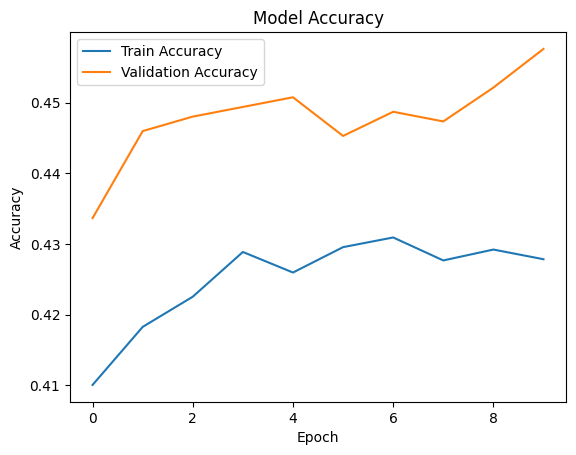

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load processed data
df = pd.read_csv("processed_sleep_data.csv")

# Convert the 'Chunk' column to numerical arrays
X = np.array([np.fromstring(chunk[1:-1], sep=' ') for chunk in df["Chunk"].values])
y = df["Label"].values

# Map labels to integers
label_map = {"W": 0, "N1": 1, "N2": 2, "N3": 3, "R": 4}
y = np.array([label_map[label.strip()] for label in y])

# Normalize the features
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Reshape X to add a channel dimension
X = X[..., np.newaxis]  # Shape: (samples, timesteps, channels)

# One-hot encode labels
y = to_categorical(y, num_classes=len(label_map))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simple CNN model
model = Sequential([
    # Conv2D
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    
    Dense(len(label_map), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()
